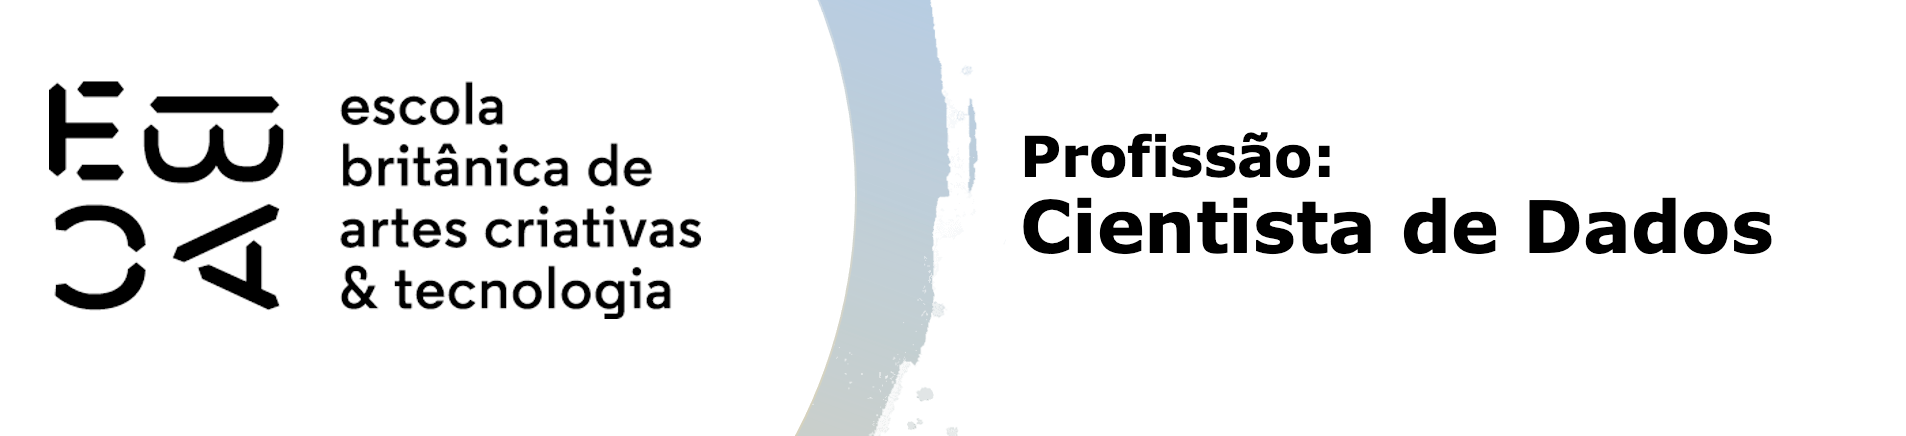

# Módulo 37 - Regressão Logística II

Vamos focar bastante na etapa de desenvolvimento do modelo, mas antes disso, vamos discutir todas as etapas envolvidas até termos um modelo em produção. Vamos falar de um modelo de *credit scoring*, em um formato também chamado de *scorecard*, que é um framework bem maduro, e totalmente aplicável em diversas realidades.

Vamos comparar o framework proposto por Siddiqi e proposto no CRISP-DM.

|Framework *Siddiqi*| Framework CRISP-DM|
|:-:|:-:|
|<div><img src="attachment:image.png" width="480"/></div>|<div><img src="attachment:image-2.png" width="415"/></div>|

Perceba que há uma correspondência bastante direta, mas com uma etapa importante, que é o *pós implantação*. É necessário fazer a gestão do modelo, até por que, já é esperado que modelos desse tipo tenham uma vida útil.

O meio bancário é extremamente regulado, e exige um nível de documentação bastante rigoroso, o que eu considero bastante oportuno, pois já presenciei altos preços sendo pagos por se negligenciar etapas que não são fortemente associadas a resultados, como documentação e planejamento, mas são capazes de mitigar riscos e fornecer bastante agilidade na necessidade de realizações de correções, além de proporcionar a gestão do conhecimento na instituição.

Vamos discutir as sete etapas, ilustrando por um problema que vimos na condução do nosso primeiro projeto. Esse desafio está originalmente disponíbel no [Kaggle](https://www.kaggle.com/), cujo link original está [aqui](https://www.kaggle.com/rikdifos/credit-card-approval-prediction).  
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%reload_ext watermark
%watermark -iv -v

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

sklearn    : 1.4.1.post1
pandas     : 2.2.1
matplotlib : 3.8.3
numpy      : 1.26.4
plotly     : 5.20.0
statsmodels: 0.14.1



## 1. Planejamento

Algumas questões importantes a serem definidas nessa etapa são:

- Identificar objetivos organizacionais
    - Público alvo
    - Priorizações (inadimplência, crescimento da carteira etc)
    - Envolvidos<br><br>
    Nesta etapa os objetivos de negócio são identificados, as prioridades do modelo, como atingir em especial determinado público, reduzir a inadimplência ou viabilizar o aumento da carteira etc. É importante identificar as pessoas envolvidas no projeto e buscar um alinhamento institucional dos objetivos - para isto, uma ferramenta muito utilizada é a matriz de responsabilidades. Abaixo está um exemplo simplificado de matriz de responsabilidades, um documento que identifica a pessoa, a etapa do projeto, e o seu nível de influência nesta etapa:
    
<div><img src="attachment:image-2.png" width="700"/></div>

- Elaborar Cronograma<br>
O cronograma é apenas um elemento do planejamento. Ele deve refetir a realidade da empresa e do projeto. Muitos lugares utilizam ferramentas sofisticadas - isto não é necessário, mas deve ser seguido caso seja prática da empresa. Não recomendo que se gaste energia excessiva em um planejamento, e se deixe margem para se trabalhar com incertezas, mas é essencial se ter uma visão inicial de todos os passos que devem ser seguidos, os interlocutores das diferentes etapas, os entregáveis, envolvidos, reuniões importantes etc. Abaixo um exemplo bem simples de cronograma, mas que deve ser adaptado a cada empresa e cada projeto, e pode ter mais detalhes. Tenha em mente que, embora o cronograma seja tipicamente desenhado de forma linear, é bastante comum (e esperado até) haverem retornos a etapas anteriores dependendo do andamento do projeto.

<div><img src="attachment:image.png" width="480"/></div>

- Plano de comunicação:<br>
Um plano de comunicação é um elemento de planejamento interessante também. Ao refletir sobre este tema fica mais claro quem deve ser envolvido em qual etapa e de que maneira. Bancos tipicamente são muito regulados e possuem diversos comitês de aprovação, é muito bom deixar os envolvidos a par do projeto, o papel de cada envolvido, quais reuniões são importantes para o projeto e onde ele será aprovado. Isto vai ajudar muito a adequar a comunicação a cada etapa.

## 2. Revisão dos dados e parâmetros do projeto

- Fontes de informação, qualidade e disponibilidade<br>
Aqui vamos avaliar os dados disponíveis. Tipicamente, para um scorecard, há um ambiente de produção (que não deve ser acessado pelo cientista de dados), um ambiente onde os dados são copiados para serem acessados sem impactar a produção (um datalake ou datawarehouse) e um ambiente de trabalho (sandbox).<br>
Lembre-se sempre de que os dados disponíveis refletem um processo, e eventualmente com limitações importantes. Tudo isso tem que ser muito bem entendido. Abaixo exemplifico de forma simplificada um trecho de um banco de dados corporativo.

<div><img src="attachment:image.png" width="800"/></div>

- Definições
    - Exclusões<br>
    Definimos exclusões como contratos ou indivíduos que não façam parte da população alvo e/ou possam distorcer os resultados, como funcionários da empresa (se houver), casos de fraude, cancelamentos e outras situações. A elaboração destas definições são decisões a serem tomadas ao longo do projeto, não há uma obrigatoriedade ou uma regra indicando certos e errados, de modo que devem ser comunicadas e discutidas com os envolvidos, e devidamente documentadas.<br>
    Exemplos:<br>
        - Fraude
        - Clientes com contratos em atraso
        - Clientes negativados em bureau de crédito
    - Janela de desempenho<br>
    Cada observação (contrato ou cliente) possui uma data de referência, a partir da qual toda informação é considerada futura (para aquela observação). A única informação futura permitida no modelo é a variável a ser classificada, no caso a indicadora de "mau". Cada observação terá, portanto, uma referência correspondente à data de contratação - note que podem haver várias, em geral são agrupadas em meses chamados 'safras'. Um desenho clássico está ilustrado abaixo, com 12 meses de desempenho (ou *performance*):
<div><img src="attachment:image-3.png" width="600"/></div>
    - Efeitos de sazonalidade<br>
    De modo a eliminar efeitos de sazonalidade, é comum utilizar um múltiplo de 12 para a janela de performance, e ainda assim, contratos amostrados em 12 safras. Não é comum se modelar sazonalidade na inadiplência.
    - Definição de "mau"<br>
    A definição mais popular de "mau" hoje em dia é um atraso superior a 90 dias em algum momento ao longo do período de desempenho. Há estudos recomendados por Siddiqi para se validar esta definição, mas após o advento do comitê de Basiléia ([mais aqui](https://www.bis.org/)), as definições oficiais são diferentes dos 90 dias com raras excessões. Outros eventos além do atraso podem incorporar a definição de mau, como execução de garantia, alguns tipos de renegociação de dívida, óbito, falência entre outros. Todos eles vão compor a definição de "mau".
    - "Bons" e "indeterminados"<br>
    Siddiqi indica a possibilidade de se definir "indeterminados", que serão excluídos da amostra na hora de treinar o modelo com um argumento de se alimentar o modelo com perfis mais discrepantes. Particularmente eu acredito que a amostra deve ser o mais fiel possível à população, e tenho visto muito mais modelos que definem o "mau", e todos que não são "maus" são "bons", sem indeterminados. Na prática creio que obteríamos modelos muito parecidos, mas com necessidades de ajustes posteriores no caso de se excluir os indeterminados da amostra.
    - Segmentações<br>
    Segmentações, como o nome sugere, consistem em separar a base em 2 ou mais sub-populações, e se construir um modelo para cada subpopulação. Os segmentos podem ser qualitativos e derivados do negócio, como o tipo do cartão de crédito por exemplo (gold, silver, platinum, black etc), podem ser intuitivas como "cliente novo" ou "cliente de outros produtos", ou ainda pode derivar de uma segmentação estatística baseada em um k-means por exemplo.<br>
    As segmentações têm o objetivo de melhorar o poder discriminante do modelo, mas por outro lado resulta em um custo adicional por se fazer a gestão de um modelo mais complexo, com mais componentes, etc.

## 3. Gerar base de desenvolvimento

Essa é tipicamente a etapa mais demorada do projeto. No próprio documento do CRISP-DM há uma estimativa de que 80% do tempo do projeto chega a ser gasto com busca, tratamento, consolidação e transformação de dados. Os passos a seguir são os seguintes:
1. Especificações da amostra
    - Por que amostrar?
    - Seleção das variáveis
    
   
2. Amostragem
    - *out of time/out of sample*
    - Tamanho amostral
    
    
    Um exemplo de desenho amostral muito popular é este abaixo, com 12 safras de desenvolvimento e 3 de validação OOT.
    
<div><img src="attachment:image-2.png" width="800"/></div>
    
    Podemos ainda fazer a divisão da base de desenvolvimento em desenvolvimento (DES) e validação *out of sample* (OOS), ou utilizar alguma outra estratégia de validação cruzada mais sofisticada.
    No nosso exemplo ilustrativo atual teremos apenas um período curto com poucas observações, de modo que estamos optando por não utilizar as bases OOS nem OOT.
    
3. Peculiaridades dos dados<br>
    Devemos identificar situações particulares ou atípicas dos dados, como crises, mudanças relevantes na população alvo, efeitos de pandemia etc, e entender se há algum período de tempo menos representativo que deva ser excluído o ter menos relevância na modelagem. Queremos que o modelo seja o mais generalizável possível, então se o período mais recente dos dados tiver algum efeito muito atípico, pode ser a melhor decisão descartá-lo.
    
4. Amostras balanceadas<br>
Amostras balanceadas em geral trazem 50% de bons e 50% de maus em um desenho *1 pra 1* de eventos e não eventos. Comparando com amostras de mesmo tamanho, esse desenho traz eficiência no sentido de estimar as razões de chances com erro padrão menor possível - fornecendo, portanto, testes mais poderosos para os parâmetros da logística. A desvantagem é que há a necessidade de uma *correção* na hora de se calcular uma probabilidade direto da equação da regressão. Há várias formas de se realizar esta correção, a mais popular é através de uma ponderação.<br>
Definimos pesos $w_i$ para cada indivíduo da amostra com a regra abaixo, e rodamos a regressão normalmente, indicando estes ponderadores:
$$
w_i = 
    \begin{cases}
    \ \rho_{bom}\pi_{bom}    & \text{se classe='bom'} \\
    \rho_{mau}\pi_{mau},              & \text{se classe='mau'}
    \end{cases}
$$
Em que $\rho_{bom}$ e $\rho_{mau}$ são as proporções na amostra de bons e maus, respectivamente, e $\pi_{bom}$ e $\pi_{mau}$ são as proporções populacionais de bons e maus respectivamente.


### 3.1 Construção da base de desenvolvimento

Os dados foram coletados com as definições discutidas no passo anterior, e as variáveis preditoras disponíveis são apenas aquelas disponíveis na ficha cadastral do cliente.

As variáveis e uma breve descrição estão na página inicial, e transcritas em tradução livre a seguir:

| Variable Name            | Description                                         | Tipo  |
| ------------------------ |:---------------------------------------------------:| -----:|
| sexo| M = 'Masculino'; F = 'Feminino' |M/F|
| posse_de_veiculo| Y = 'possui'; N = 'não possui' |Y/N|
| posse_de_imovel| Y = 'possui'; N = 'não possui' |Y/N|
| qtd_filhos| Quantidade de filhos |inteiro|
| tipo_renda|Tipo de renda (ex: assaliariado, autônomo etc) | texto |
| educacao| Nível de educação (ex: secundário, superior etc) |texto|
| estado_civil | Estado civil (ex: solteiro, casado etc)| texto |
| tipo_residencia | tipo de residência (ex: casa/apartamento, com os pais etc) | texto |
| idade | idade em anos |inteiro|
| tempo de emprego | tempo de emprego em anos |inteiro|
| possui_celular | Indica se possui celular (1 = sim, 0 = não) |binária|
| possui_fone_comercial | Indica se possui telefone comercial (1 = sim, 0 = não) |binária|
| possui_fone | Indica se possui telefone (1 = sim, 0 = não) |binária|
| possui_email | Indica se possui e-mail (1 = sim, 0 = não) |binária|
| qt_pessoas_residencia | quantidade de pessoas na residência |inteiro|
| **mau** | indicadora de mau pagador (True = mau, False = bom) |binária|

In [2]:
pasta = './proj01/'
df = pd.read_csv(pasta+'demo01.csv')
df.head() 
print('numero de linhas: {0} \nnúmero de colunas: {1}'.format(df.shape[0], df.shape[1]))
df.mau.value_counts(normalize=True)

numero de linhas: 16650 
número de colunas: 16


mau
False    0.976577
True     0.023423
Name: proportion, dtype: float64

In [3]:
df.mau.value_counts()

mau
False    16260
True       390
Name: count, dtype: int64

In [4]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()

metadados

,dtype,nmissing,valores_unicos
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6
idade,float64,0,5298
tempo_emprego,float64,0,3005


In [5]:
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')

### 3.2 Amostragens

É bastante comum se fazer amostras de validação *Out of Sample* (OOS), que são amostras aleatórias dentro da base de desenvolvimento, de 20 a 30% dos dados separados para conduzir a validação do modelo, e principalmente amostras *Out of Time* (OOT), que são períodos recentes separados para serem utilizados somente para as validações finais do modelo (e não podem ser utilizados no treinamento dos algoritmos).

Na presente situação, há muito poucas observações frente ao número de parâmetros. Uma desvantagem da realização de amostragem para validação cruzada é que abrimos mão de informação que poderia ser utilizada no treinamento do modelo - e neste caso, esta informação é muito valiosa, pois o tamanho da amostra é pequeno frente à quantidade de parâmetros que temos para avaliar - temos apenas 390 clientes maus, o que é um tamanho amostral bastante limitado. 

### 3.3 Ponderações

Abaixo vamos ilustrar como seria a ponderação, caso tivéssemos amostrado todos os clientes maus, e um cliente bom para cada mau (390 de cada).

In [6]:
df_amostra = pd.concat([df[df.mau==1], df[df.mau==0].sample(n=390)])
tab_am = df_amostra.mau.value_counts()
tab_am


mau
1    390
0    390
Name: count, dtype: int64

In [7]:
tab_pop = df.mau.value_counts()
tab_pop

mau
0    16260
1      390
Name: count, dtype: int64

In [8]:
rho_mau = tab_am.loc[1]/tab_am.sum()
rho_bom = tab_am.loc[0]/tab_am.sum()

pi_mau = tab_pop.loc[1]/tab_pop.sum()
pi_bom = tab_pop.loc[0]/tab_pop.sum()

wbom = pi_bom*rho_bom
wmau = pi_mau*rho_mau

print(f'wbom= {wbom}, wmau={wmau}')

wbom= 0.4882882882882883, wmau=0.011711711711711712


In [9]:
df_amostra.loc[df_amostra.mau == 1,'w']=wmau
df_amostra.loc[df_amostra.mau == 0,'w']=wbom

In [10]:
df_amostra.groupby('mau')['w'].sum()/df_amostra.w.sum()

mau
0    0.976577
1    0.023423
Name: w, dtype: float64

## 4. Desenvolvimento do scorecard

Nesta etapa, tipicamente fazemos diversas versões de modelo para cada segmento, e eventualmente, diversos modelos diferentes com diferentes algoritmos, comparamos, e escolhemos o melhor.

Vale frisar que normalmente a fonte de melhoria do modelo mais importante vai estar nas variáveis de entrada. Quanto melhor forem e mais bem trabalhadas, melhor vai ser o modelo. Há melhorias com relação à parametrização do modelo, algoritmo, linearizações, interações etc, e em geral buscamos todos esses fatores que possam melhorar a capacidade discriminante. Os passos dessa etapa:

- Análise exploratória
- Seleção de variáveis
- Tratamento de valores faltantes e outliers
- Agrupamento de categorias
- Equação preliminar
- Inferência de rejeitados
- Produção do escorecard final
- Validação

In [11]:
metadados

,dtype,nmissing,valores_unicos
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6
idade,float64,0,5298
tempo_emprego,float64,0,3005


### 4.1 Análise exploratória

No módulo anterior vimos algumas análises interessantes em que fizemos uma análise bivariada para checar as distribuições marginais (histogramas, gráficos de barras e tabelas de frequencias), montamos gráficos de WOE para cada variável e calculamos o IV. Essa é a análise exploratória básica. Sempre podemos avaliar segmentos diferentes e fazer análises para responder a perguntas diferentes, mas pertinentes ao projeto.

In [12]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [13]:
iv_sexo = IV(df.sexo, df.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.5%


In [14]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,float64,0.0,5298.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [15]:
var='idade'
IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)

0.03112664138172465

In [16]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.005461
posse_de_veiculo,object,0.0,2.0,covariavel,0.002167
posse_de_imovel,object,0.0,2.0,covariavel,0.030016
qtd_filhos,int64,0.0,8.0,covariavel,0.002892
tipo_renda,object,0.0,5.0,covariavel,inf
educacao,object,0.0,5.0,covariavel,inf
estado_civil,object,0.0,5.0,covariavel,0.047624
tipo_residencia,object,0.0,6.0,covariavel,0.015773
idade,float64,0.0,5298.0,covariavel,0.031127
tempo_emprego,float64,0.0,3005.0,covariavel,0.098035


In [17]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

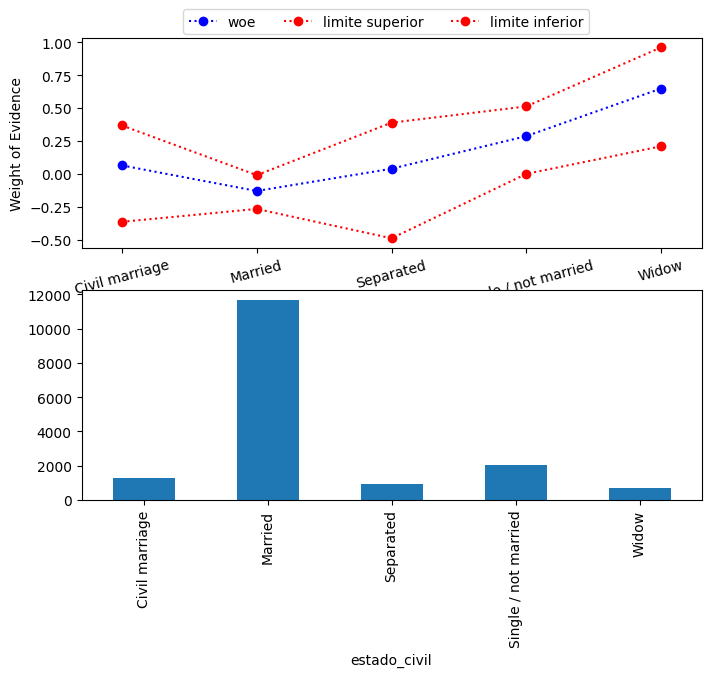

In [18]:
biv_discreta('estado_civil', df);

c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Commercial associate,3728,98,0.025614,Commercial associate,3826,0.002554,0.030622,0.020607,-3.638660,-3.454946,-3.861315,0.091657,0.275371,-0.130998
Pensioner,2722,78,0.027857,Pensioner,2800,0.003110,0.033955,0.021759,-3.552413,-3.348169,-3.805724,0.177903,0.382148,-0.075407
State servant,1425,26,0.017919,State servant,1451,0.003483,0.024750,0.011087,-4.003831,-3.673869,-4.490799,-0.273514,0.056448,-0.760483
Student,8,0,0.000000,Student,8,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Working,8377,188,0.021950,Working,8565,0.001583,0.025053,0.018846,-3.796803,-3.661380,-3.952409,-0.066487,0.068936,-0.222092


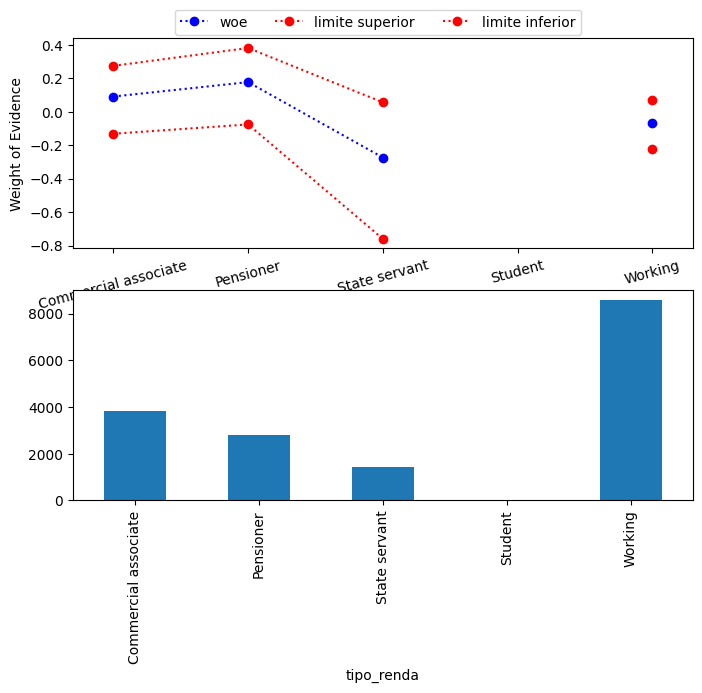

In [19]:
biv_discreta('tipo_renda', df)

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\116977603.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.tipo_renda.replace({'Student': 'St. ser./Stud.', 'State servant': 'St. ser./Stud.'}, inplace=True)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Commercial associate,3728,98,0.025614,Commercial associate,3826,0.002554,0.030622,0.020607,-3.638660,-3.454946,-3.861315,0.091657,0.275371,-0.130998
Pensioner,2722,78,0.027857,Pensioner,2800,0.003110,0.033955,0.021759,-3.552413,-3.348169,-3.805724,0.177903,0.382148,-0.075407
St. ser./Stud.,1433,26,0.017820,St. ser./Stud.,1459,0.003464,0.024615,0.011026,-4.009429,-3.679494,-4.496387,-0.279112,0.050823,-0.766071
Working,8377,188,0.021950,Working,8565,0.001583,0.025053,0.018846,-3.796803,-3.661380,-3.952409,-0.066487,0.068936,-0.222092


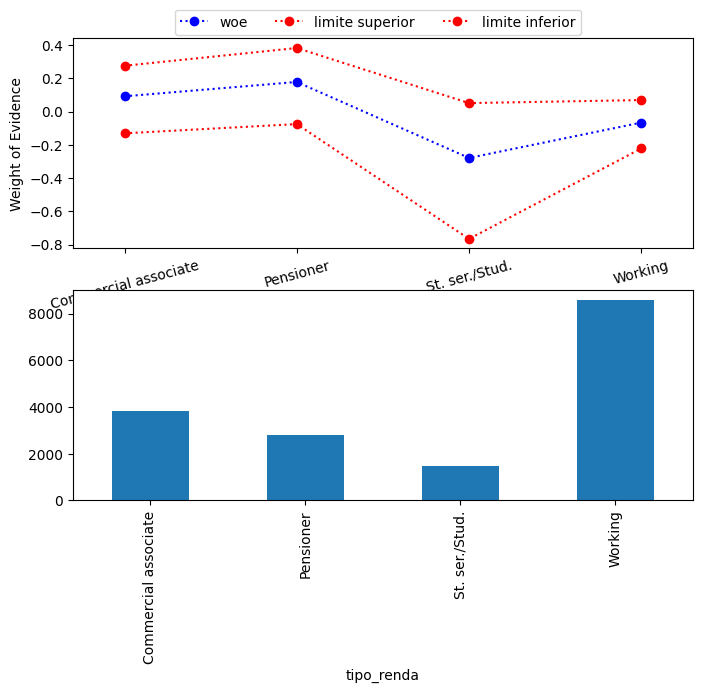

In [20]:
df2 = df.copy()
df2.tipo_renda.replace({'Student': 'St. ser./Stud.', 'State servant': 'St. ser./Stud.'}, inplace=True)
biv_discreta('tipo_renda', df2)

In [21]:
IV(df2.tipo_renda, df.mau)

0.0160100868136515

c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Program Files\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic degree,17,0,0.000000,Academic degree,17,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
Higher education,4436,115,0.025269,Higher education,4551,0.002326,0.029830,0.020708,-3.652576,-3.481955,-3.856295,0.077740,0.248362,-0.125978
Incomplete higher,624,25,0.038521,Incomplete higher,649,0.007554,0.053355,0.023687,-3.217275,-2.875962,-3.718861,0.513042,0.854354,0.011456
Lower secondary,181,7,0.037234,Lower secondary,188,0.013809,0.064475,0.009993,-3.252587,-2.674833,-4.595800,0.477730,1.055483,-0.865483
Secondary / secondary special,11002,243,0.021610,Secondary / secondary special,11245,0.001371,0.024297,0.018922,-3.812771,-3.692789,-3.948336,-0.082454,0.037528,-0.218020


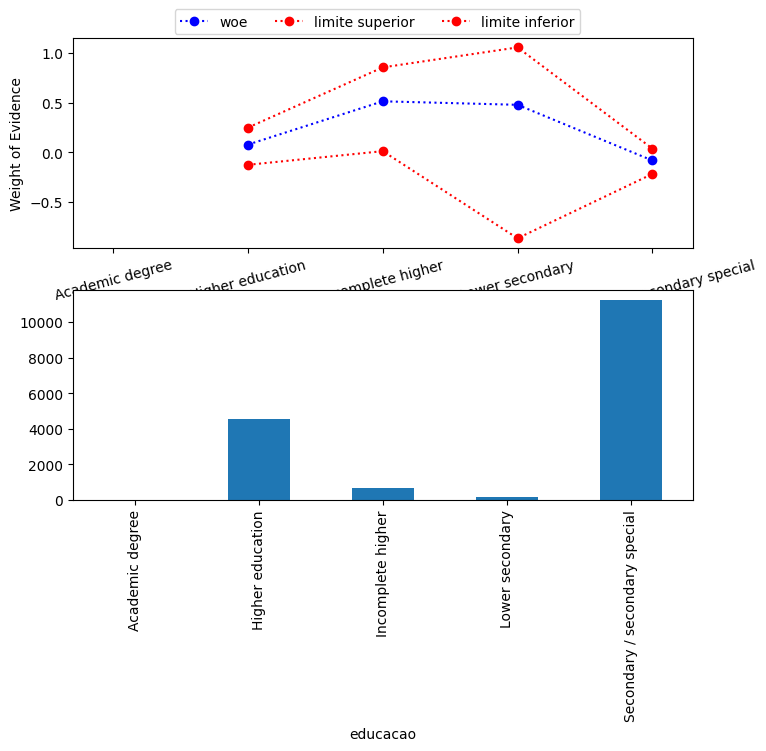

In [22]:
biv_discreta('educacao', df2)

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\1467603618.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.educacao.replace({'Academic degree':'Academic/Higher', 'Higher education': 'Academic/Higher'}, inplace=True)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic/Higher,4453,115,0.025175,Academic/Higher,4568,0.002318,0.029719,0.020631,-3.656401,-3.485791,-3.860113,0.073915,0.244526,-0.129796
Incomplete higher,624,25,0.038521,Incomplete higher,649,0.007554,0.053355,0.023687,-3.217275,-2.875962,-3.718861,0.513042,0.854354,0.011456
Lower secondary,181,7,0.037234,Lower secondary,188,0.013809,0.064475,0.009993,-3.252587,-2.674833,-4.595800,0.477730,1.055483,-0.865483
Secondary / secondary special,11002,243,0.021610,Secondary / secondary special,11245,0.001371,0.024297,0.018922,-3.812771,-3.692789,-3.948336,-0.082454,0.037528,-0.218020


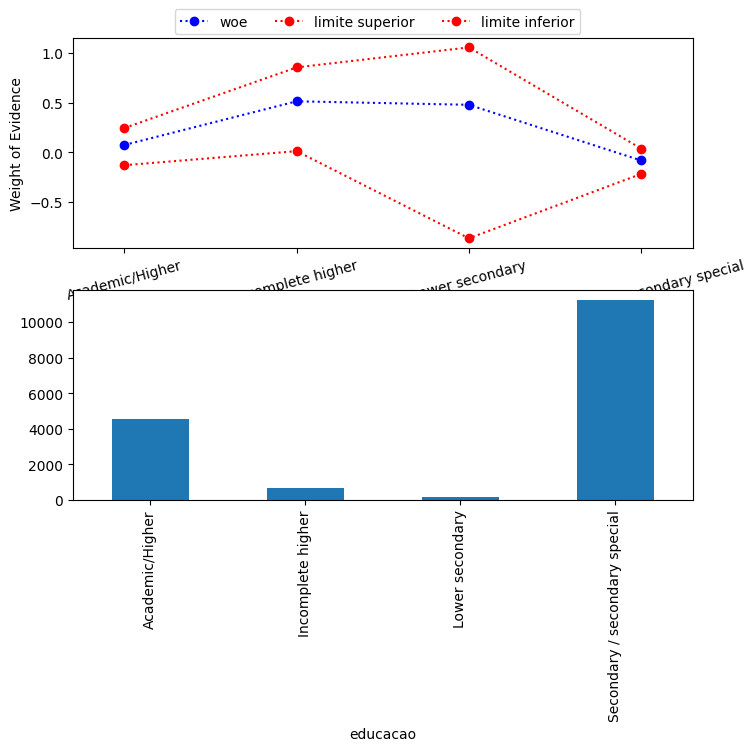

In [23]:
df2.educacao.replace({'Academic degree':'Academic/Higher', 'Higher education': 'Academic/Higher'}, inplace=True)
biv_discreta('educacao', df2)

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2364289996.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.educacao.replace({'Incomplete higher':'Academic/Higher',


0.009807762437895476

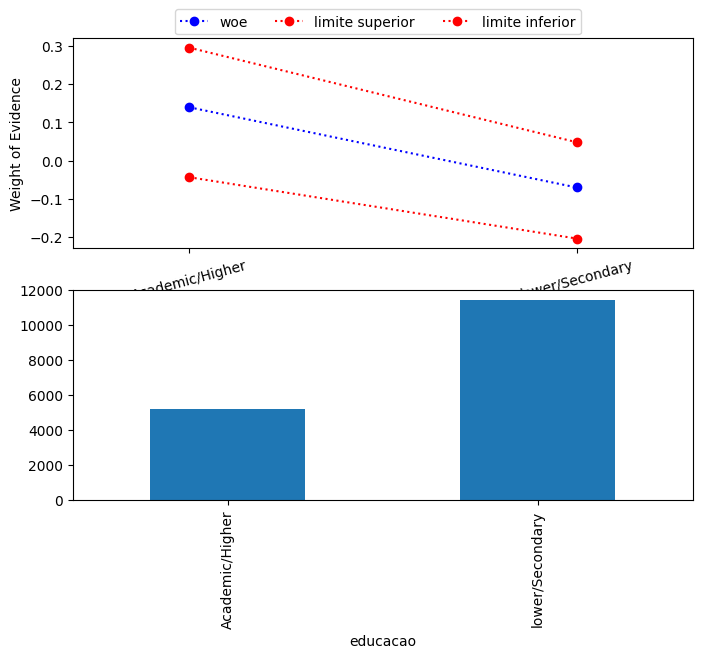

In [24]:
df2.educacao.replace({'Incomplete higher':'Academic/Higher', 
                      'Lower secondary':'lower/Secondary',
                      'Secondary / secondary special': 'lower/Secondary'
                     }, inplace=True)
biv_discreta('educacao', df2)
IV(df2.educacao, df.mau)

In [25]:

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


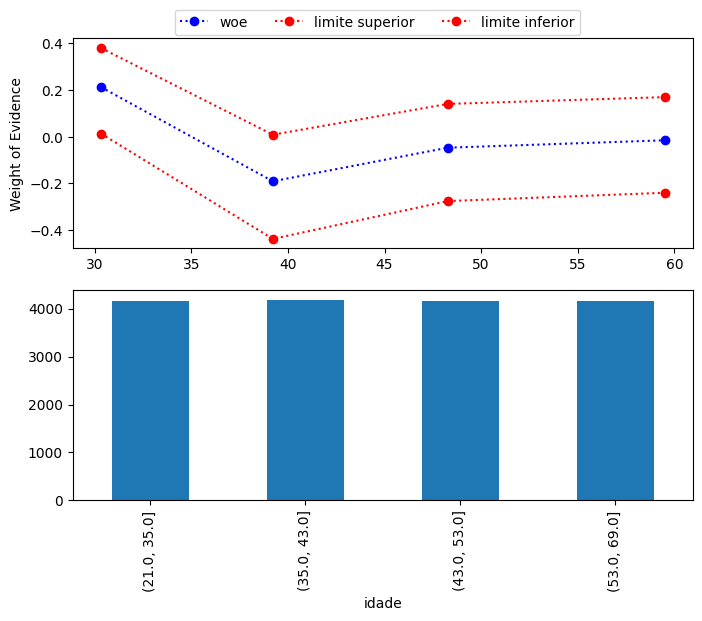

In [26]:
biv_continua('idade', 4, df)

In [27]:
df.columns
df.tempo_emprego.describe()

count    16650.000000
mean      -161.416446
std        376.843912
min      -1000.665753
25%          1.183562
50%          4.691781
75%          9.088356
max         42.906849
Name: tempo_emprego, dtype: float64

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


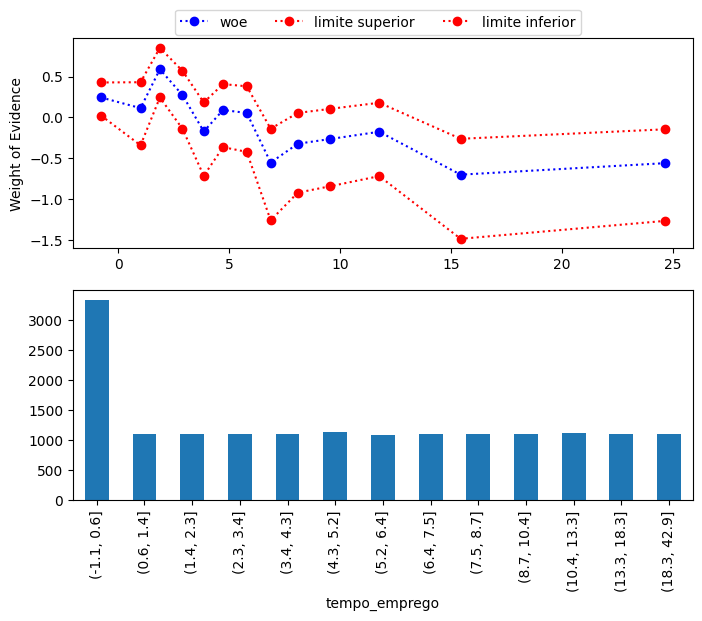

In [28]:
df2.loc[df2['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df2)

### 4.2 Desenvolvimento do modelo

Nessa etapa vamos desenvolver o scorecard inicial. Tipicamente é muito comum rodarmos diversas versões de modelo, identificando ajustes, variáveis com coeficientes muito diferentes da expectativa a partir da análise descritiva, até mesmo o surgimento de novas ideias de variáveis que possam melhorar o scorecard.

In [29]:
# ajuda para definir a equação da regressão
' + '.join(list(df.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + possui_celular + possui_fone_comercial + possui_fone + possui_email + qt_pessoas_residencia + mau + bom'

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic/Higher,5077,140,0.026835,Academic/Higher,5217,0.002237,0.031222,0.022449,-3.590833,-3.434929,-3.773796,0.139483,0.295388,-0.043480
lower/Secondary,11183,250,0.021867,lower/Secondary,11433,0.001368,0.024548,0.019185,-3.800689,-3.682289,-3.934229,-0.070372,0.048028,-0.203913


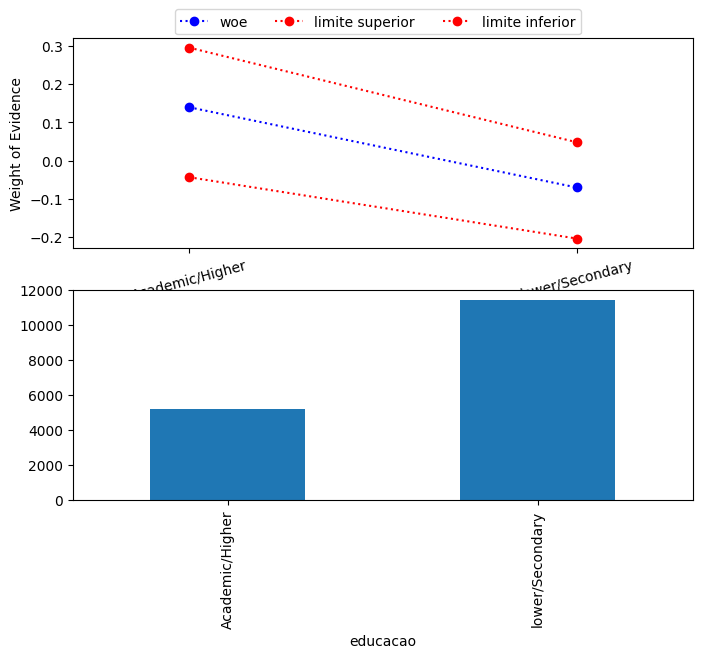

In [30]:
biv_discreta('educacao', df2)

In [31]:
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego + 
    possui_celular + possui_fone_comercial + possui_fone + possui_email + 
    qt_pessoas_residencia
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16626
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1804.0
Date:                Fri, 22 Mar 2024   Deviance:                       3607.9
Time:                        11:43:29   Pearson chi2:                 5.03e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005450
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -3.2764      0.765     -4.282      0.000      -4.776      -1.777
sexo[T.M]                                  0.2212      0.120      1.841      0.066      -0.014       0.457
posse_de_veiculo[T.Y]                     -0.1467      0.117     -1.252      0.210      -0.376       0.083
posse_de_imovel[T.Y]                      -0.3046      0.111     -2.755      0.006      -0.521      -0.088
tipo_renda[T.Pensioner]                   -0.0206      0.227     -0.091      0.928      -0.466       0.425
tipo_renda[T.St. ser./Stud.]              -0.2603      0.227     -1.148      0.251      -0.705       0.184
tipo_renda[T.Working]                     -0.1303      0.129     -1.013      0.311      -0.383       0.122
educacao[T.lower/Secondary]               -0.2387      0.113     -2.118      0.034      -0.460      -0.018
estado_civil[T.Married]                   -0.1727      0.192     -0.899      0.369      -0.549       0.204
estado_civil[T.Separated]                  1.9503      0.720      2.709      0.007       0.539       3.361
estado_civil[T.Single / not married]       2.1056      0.673      3.130      0.002       0.787       3.424
estado_civil[T.Widow]                      2.6454      0.717      3.689      0.000       1.240       4.051
tipo_residencia[T.House / apartment]      -0.0641      0.724     -0.089      0.929      -1.483       1.355
tipo_residencia[T.Municipal apartment]     0.4347      0.759      0.573      0.567      -1.052       1.922
tipo_residencia[T.Office apartment]        0.5404      0.857      0.631      0.528      -1.139       2.220
tipo_residencia[T.Rented apartment]       -0.0528      0.833     -0.063      0.950      -1.686       1.580
tipo_residencia[T.With parents]           -0.4179      0.768     -0.544      0.586      -1.924       1.088
qtd_filhos                                -1.8514      0.670     -2.763      0.006      -3.165      -0.538
idade                                     -0.0082      0.007     -1.229      0.219      -0.021       0.005
tempo_emprego                             -0.0463      0.012     -3.982      0.000      -0.069      -0.024
possui_celular                            -3.2764      0.765     -4.282      0.000      -4.776      -1.777
possui_fone_comercial                      0.2384      0.132      1.805      0.071      -0.020       0.497
possui_fone                                0.0783      0.117      0.671      0.502      -0.150       0.307
possui_email                              -0.1774      0.195     -0.908      0.364      -0.561       0.206
qt_pessoas_residencia                      1.9219      0.663      2.900      0.004       0.623       3.221
=======================================================================================

In [32]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
tipo_renda,object,0.0,5.0,covariavel,inf
educacao,object,0.0,5.0,covariavel,inf
tempo_emprego,float64,0.0,3005.0,covariavel,0.098035
estado_civil,object,0.0,5.0,covariavel,0.047624
idade,float64,0.0,5298.0,covariavel,0.031127
posse_de_imovel,object,0.0,2.0,covariavel,0.030016
tipo_residencia,object,0.0,6.0,covariavel,0.015773
possui_fone_comercial,int64,0.0,2.0,covariavel,0.010950
sexo,object,0.0,2.0,covariavel,0.005461
possui_fone,int64,0.0,2.0,covariavel,0.003689


In [33]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'tipo_renda + educacao + tempo_emprego + estado_civil + idade + posse_de_imovel + tipo_residencia + possui_fone_comercial + sexo + possui_fone + qt_pessoas_residencia + qtd_filhos + posse_de_veiculo + possui_email + possui_celular + mau + bom'

In [34]:
formula = '''
    mau ~ tempo_emprego + estado_civil 
    + idade + posse_de_imovel + tipo_residencia 
    + possui_fone_comercial + educacao
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16635
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1810.9
Date:                Fri, 22 Mar 2024   Deviance:                       3621.8
Time:                        11:43:30   Pearson chi2:                 1.71e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.004622
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.7789      0.774     -3.592      0.000      -4.295      -1.262
estado_civil[T.Married]                   -0.1620      0.191     -0.847      0.397      -0.537       0.213
estado_civil[T.Separated]                  0.0413      0.279      0.148      0.882      -0.505       0.587
estado_civil[T.Single / not married]       0.2204      0.221      0.996      0.319      -0.213       0.654
estado_civil[T.Widow]                      0.6827      0.267      2.556      0.011       0.159       1.206
posse_de_imovel[T.Y]                      -0.3121      0.110     -2.830      0.005      -0.528      -0.096
tipo_residencia[T.House / apartment]      -0.0100      0.722     -0.014      0.989      -1.425       1.405
tipo_residencia[T.Municipal apartment]     0.4840      0.757      0.640      0.522      -0.999       1.967
tipo_residencia[T.Office apartment]        0.6366      0.854      0.745      0.456      -1.038       2.311
tipo_residencia[T.Rented apartment]       -0.0090      0.831     -0.011      0.991      -1.638       1.620
tipo_residencia[T.With parents]           -0.3711      0.767     -0.484      0.628      -1.874       1.132
educacao[T.lower/Secondary]               -0.2106      0.111     -1.905      0.057      -0.427       0.006
tempo_emprego                             -0.0506      0.010     -5.111      0.000      -0.070      -0.031
idade                                     -0.0086      0.005     -1.720      0.085      -0.018       0.001
possui_fone_comercial                      0.2701      0.123      2.195      0.028       0.029       0.511
==========================================================================================================
"""

In [35]:
formula = '''
    mau ~ tempo_emprego + estado_civil 
    + idade + posse_de_imovel
    + possui_fone_comercial
'''

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                16650
Model:                            GLM   Df Residuals:                    16641
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1816.3
Date:                Fri, 22 Mar 2024   Deviance:                       3632.6
Time:                        11:43:30   Pearson chi2:                 1.71e+04
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003974
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.9054      0.286    -10.171      0.000      -3.465      -2.345
estado_civil[T.Married]                 -0.1457      0.191     -0.763      0.446      -0.520       0.229
estado_civil[T.Separated]                0.0590      0.278      0.212      0.832      -0.486       0.604
estado_civil[T.Single / not married]     0.2429      0.221      1.101      0.271      -0.190       0.676
estado_civil[T.Widow]                    0.6828      0.267      2.560      0.010       0.160       1.206
posse_de_imovel[T.Y]                    -0.3293      0.108     -3.058      0.002      -0.540      -0.118
tempo_emprego                           -0.0492      0.010     -4.991      0.000      -0.068      -0.030
idade                                   -0.0090      0.005     -1.876      0.061      -0.018       0.000
possui_fone_comercial                    0.2539      0.122      2.075      0.038       0.014       0.494
========================================================================================================
"""

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Academic/Higher,5077,140,0.026835,Academic/Higher,5217,0.002237,0.031222,0.022449,-3.590833,-3.434929,-3.773796,0.139483,0.295388,-0.043480
lower/Secondary,11183,250,0.021867,lower/Secondary,11433,0.001368,0.024548,0.019185,-3.800689,-3.682289,-3.934229,-0.070372,0.048028,-0.203913


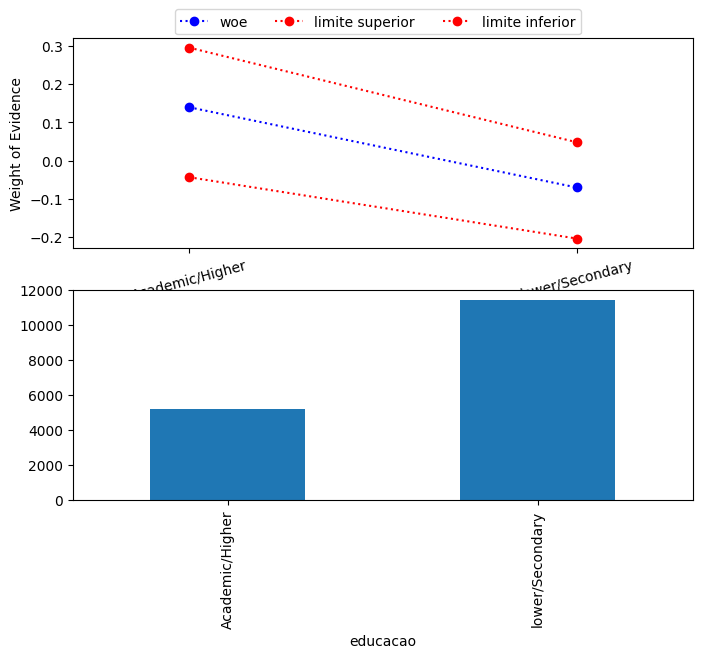

In [36]:
biv_discreta('educacao', df2)

In [37]:
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 97.6% 
AUC: 61.5% 
GINI: 23.0%
KS: 18.5%


## 5. Relatórios gerenciais do modelo

Nesta etapa vamos avaliar as contribuições do nosso scorecard ao processo. A avaliação numérica/estatística, que avalia o poder discriminante já foi realizada no passo anterior. Agora é o momento de avaliar uma expectativa de redução na inadimplência ou ganho financeiro.

Duas análises populares são:

- Tabela de ganhos
- Relatório de características

### 5.1 Relatórios de características

In [38]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]



C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


,tempo_emprego,distribuição,score,tx_ev
0,"(-1.001, 0.6]",20.0%,2.8%,3.0%
1,"(0.6, 3.384]",20.0%,2.9%,3.3%
2,"(3.384, 6.367]",20.0%,2.5%,2.3%
3,"(6.367, 10.436]",19.9%,2.1%,1.6%
4,"(10.436, 42.907]",20.0%,1.4%,1.5%


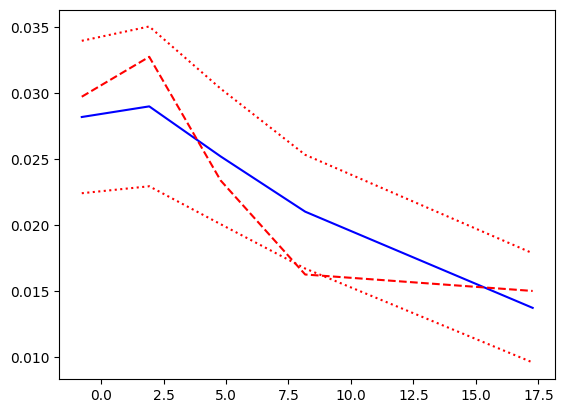

In [39]:
tg = perfil_var(df2, 'tempo_emprego', ncat=5)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


,distribuição,score,tx_ev
idade,,,
"(22.029, 33.148]",0.20024,0.028611,0.028794
"(33.148, 40.06]",0.19988,0.023316,0.021935
"(40.06, 47.213]",0.19988,0.020989,0.018029
"(47.213, 55.611]",0.20006,0.019848,0.027319
"(55.611, 68.91]",0.19994,0.024347,0.021027


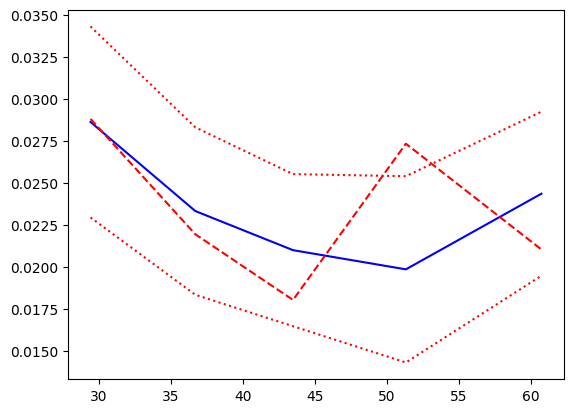

In [40]:
tg = perfil_var(df2, 'idade', ncat=5)
tg

C:\Users\Eduardo\AppData\Local\Temp\ipykernel_1912\2325786389.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))


,distribuição,score,tx_ev
score,,,
"(0.00135, 0.016]",0.20030,0.011965,0.014393
"(0.016, 0.0201]",0.19988,0.018394,0.014123
"(0.0201, 0.0235]",0.19982,0.021550,0.022242
"(0.0235, 0.0301]",0.20000,0.026773,0.028829
"(0.0301, 0.0885]",0.20000,0.038448,0.037538


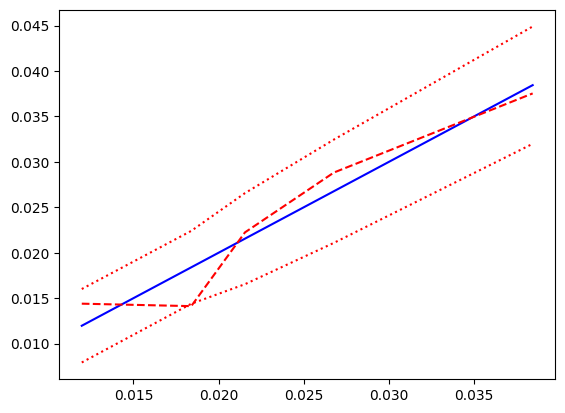

In [41]:
perfil_var(df2, 'score', ncat=5)

### Tabela de ganhos 

In [42]:
df3 = df2.sort_values(by='score').reset_index().copy()
df3['tx_mau_acum'] = df3.mau.cumsum()/df3.shape[0]

df3['pct_mau_acum'] = df3.mau.cumsum()/df3.mau.sum()
df3['red_mau_acum'] = 1-df3.pct_mau_acum

df3['pct_aprovacao'] = np.array(range(df3.shape[0]))/df3.shape[0]
df3.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,...,possui_fone,possui_email,qt_pessoas_residencia,mau,bom,score,tx_mau_acum,pct_mau_acum,red_mau_acum,pct_aprovacao
0,15920,F,N,Y,0,Commercial associate,lower/Secondary,Married,House / apartment,62.079452,...,0,0,2.0,0,1,0.002351,0.0,0.0,1.0,0.00000
1,15919,F,N,Y,0,Commercial associate,lower/Secondary,Married,House / apartment,62.079452,...,0,0,2.0,0,1,0.002351,0.0,0.0,1.0,0.00006
2,13872,F,N,Y,0,Commercial associate,lower/Secondary,Married,House / apartment,62.745205,...,0,0,2.0,0,1,0.002633,0.0,0.0,1.0,0.00012
3,12956,F,N,Y,0,Working,lower/Secondary,Married,House / apartment,61.189041,...,0,0,2.0,0,1,0.002657,0.0,0.0,1.0,0.00018
4,12957,F,N,Y,0,Working,lower/Secondary,Married,House / apartment,61.189041,...,0,0,2.0,0,1,0.002657,0.0,0.0,1.0,0.00024


In [43]:
fig = px.line(df3, x="pct_aprovacao", y="tx_mau_acum", title='Taxa de maus por %aprovação')
fig.show()

In [44]:
fig = px.line(df3, x="pct_aprovacao", y="red_mau_acum", title='Redução na inadimplência por %aprovação')
fig.show()

In [46]:
tmp = df2.sort_values(by=['idade_cat','score'], ascending=True).copy()
tmp['freq']=1

tmp['freq_ac'] = tmp.groupby(['idade_cat'])['freq'].transform(lambda x: x.cumsum())
tmp['maus_ac'] = tmp.groupby(['idade_cat'])['mau'].transform(lambda x: x.cumsum())
tmp['freq_fx_idade'] = tmp.groupby(['idade_cat'])['freq'].transform(lambda x: x.sum())

tmp['pct_aprovados'] = tmp.freq_ac/tmp['freq_fx_idade']
tmp['tx_maus_pto_corte'] = tmp['maus_ac']/tmp['freq_ac']

tmp

KeyError: 'idade_cat'

In [48]:
fig = px.line(tmp, x="score", y="pct_aprovados", color='idade_cat', title='Taxa de maus por %aprovação')
fig.show()

NameError: name 'tmp' is not defined

## 6. Implementação
Dependendo do tamanho da empresa, tipicamente esta etapa é especificada a uma área especialista. Para empresas mais enxutas, a mesma equipe (ou o mesmo profissional) fica encarregado desta etapa. Há diversas formas diferentes de se implementar um modelo de scorecard, mas em todas elas devem ser executados as seguintes atividades:

- Homologação: Consiste em verificar da forma mais exaustiva possível que foi implementada a equação/modelo desejado, e sem erros. Tipicamente é preparada uma massa de testes, e executada pelo programa de implementação, antes de colocá-lo em produção efetivamente.
- Desenvolvimento da estratégia: O modelo será utilizado para tomar decisões. Nas etapas anteriores, o que foi produzido é uma equação que avalia a probabilidade de um evento. Não há decisões efetivas de negócio aqui. A estratégia consiste nas decisões a serem direcionadas em detrimento desses escores.

## 7. Pós implementação

Após a implementação, há duas características a serem monitoradas:

- O desempenho da estratégia: consiste em monitorar o negócio, a inadimplência, a qualidade do crédito, se a estratégia especificada está sendo respeitada etc. Tudo isso em geral se deseja ver ao longo do tempo, com análises e filtragens específicas, por produto, regional etc.
- O desempenho do modelo: Todo produto tem um ciclo de vida, o mesmo se espera de um modelo como o de crediscoring. Os diferentes níveis de risco estão de fato resultando em níveis diferentes de inadimplência? As variáveis continuam com o mesmo poder de discriminação? Os patamares gerais de inadimplência permanecem? Todas essas são características que podem vir diferente da expectativa quando o modelo entra no ar pela primeira vez, e podem se alterar no tempo. Dependendo deste monitoramento podem se disparar diversas ações de ajustes no modelo.

## Referências

|||
|:-|:-|
|<div><img src="attachment:image.png" width="150"/></div>| **Intelligent Credit Scoring**: Building and Implementing Better Credit Risk Scorecards, por Naeem Siddiqi Capa dura, 10 janeiro 2017, editora Wiley [link](https://github.com/thonyeh/Linear-Models/blob/master/Siddiqi%2C%20Naeem%20-%20Intelligent%20credit%20scoring%20_%20building%20and%20implementing%20better%20creditrisk%20scorecards%20(2017%2C%20Wiley).pdf)|


# Leitura adicional

- Exportar modelos para PMML com o pacote Nyoka [link](https://github.com/nyoka-pmml/nyoka)